# AdventureWorks Försäljningsanalys

**Syfte**: Analysera försäljningsdata från AdventureWorks-databasen för att identifiera trender och möjligheter.

In [8]:
# Setup och anslutning till SQL Server
# Skolvideo: Python + SQL Server
import pandas as pd
import pymssql  # Enklare alternativ till pyodbc
import matplotlib.pyplot as plt
import seaborn as sns

# Docker-anslutning
server = 'localhost'
database = 'AdventureWorks2022'
user = 'sa'
password = 'StrongPass2026'

# Testa anslutning
try:
    conn = pymssql.connect(server=server, user=user, password=password, database=database)
    print("✅ Anslutning till SQL Server lyckades")
    conn.close()
except Exception as e:
    print("❌ Kunde inte ansluta:", e)


✅ Anslutning till SQL Server lyckades


## 1. Antal produkter per kategori

**Affärsfråga**: Hur många produkter finns i varje kategori?

**Metod**: JOIN Production.ProductCategory, ProductSubcategory och Product, räkna unika produkter per kategori.


C:\Users\riera\AppData\Local\Temp\ipykernel_24648\387498437.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


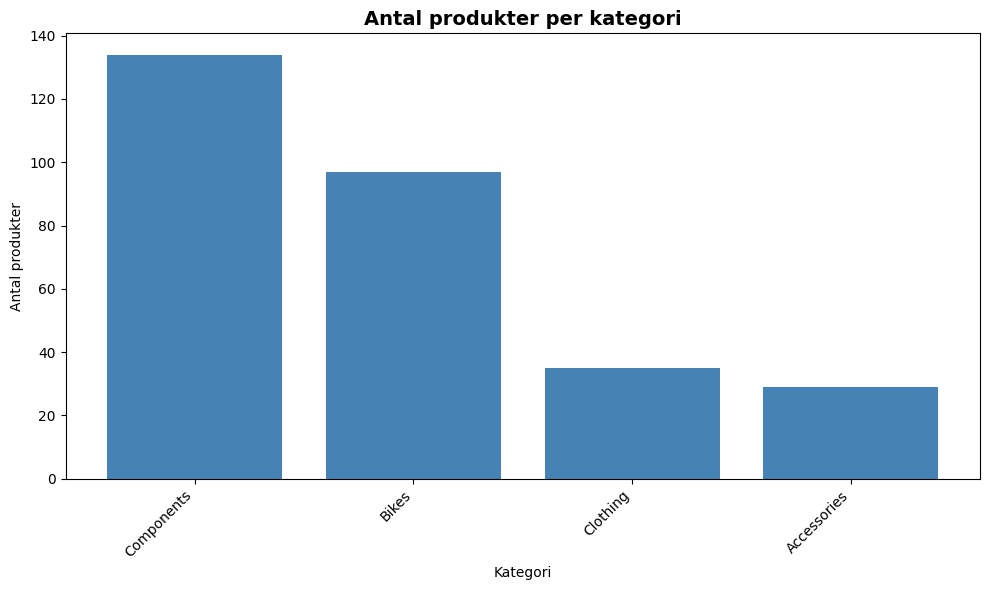

,Kategori,AntalProdukter
0,Components,134
1,Bikes,97
2,Clothing,35
3,Accessories,29


In [9]:
# Skolvideo: JOINS
query = """
SELECT 
    pc.Name AS Kategori,
    COUNT(p.ProductID) AS AntalProdukter
FROM Production.ProductCategory pc
LEFT JOIN Production.ProductSubcategory ps ON pc.ProductCategoryID = ps.ProductCategoryID
LEFT JOIN Production.Product p ON ps.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY AntalProdukter DESC;
"""

# Hämtar data nu
conn = pymssql.connect(server=server, user=user, password=password, database=database)
df = pd.read_sql(query, conn)
conn.close()

# Visualisering
plt.figure(figsize=(10, 6))
plt.bar(df['Kategori'], df['AntalProdukter'], color='steelblue')
plt.title('Antal produkter per kategori', fontsize=14, fontweight='bold')
plt.xlabel('Kategori')
plt.ylabel('Antal produkter')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

df  # Visar data nedan


**Insikt**: 

Kategorin **Components** har flest produkter (134 st), följt av **Bikes** (97 st). **Accessories** har minst antal produkter (29 st). Detta visar att företaget fokuserar mest på komponenter och cyklar, medan tillbehör blir en mindre del av sortimentet.


## 2. Försäljning per produktkategori

**Affärsfråga**: Vilka produktkategorier genererar mest intäkter?

**Metod**: JOIN kategoritabeller med Sales.SalesOrderDetail, summera LineTotal per kategori, sortera högst till lägst.

C:\Users\riera\AppData\Local\Temp\ipykernel_24648\2354183507.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(query, conn)


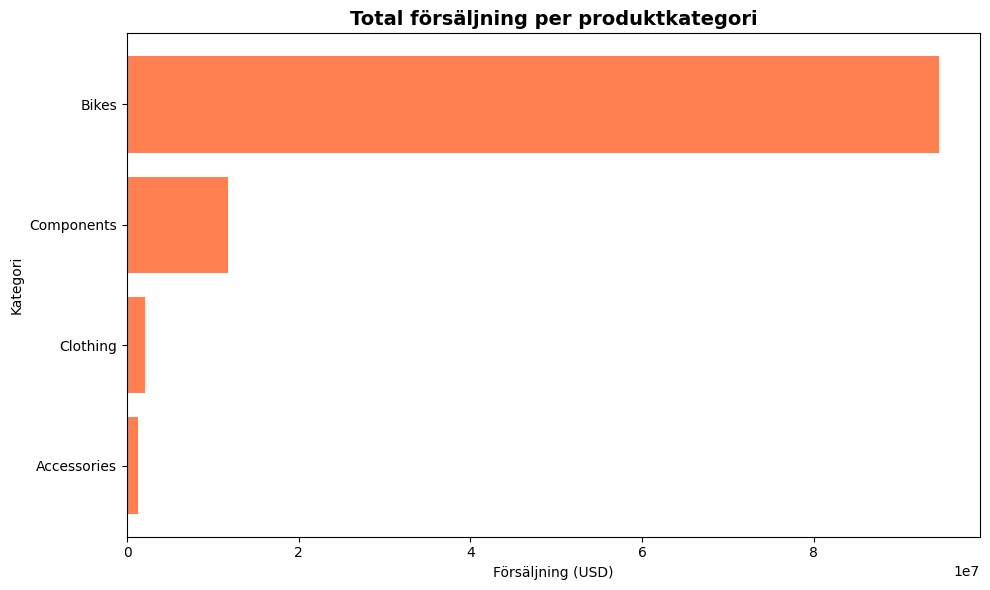

,Kategori,TotalForsaljning
0,Bikes,9.465117e+07
1,Components,1.180259e+07
2,Clothing,2.120543e+06
3,Accessories,1.272073e+06


In [10]:
# Skolvideo: JOINS
query = """
SELECT 
    pc.Name AS Kategori,
    SUM(sod.LineTotal) AS TotalForsaljning
FROM Production.ProductCategory pc
JOIN Production.ProductSubcategory ps ON pc.ProductCategoryID = ps.ProductCategoryID
JOIN Production.Product p ON ps.ProductSubcategoryID = p.ProductSubcategoryID
JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalForsaljning DESC;
"""

conn = pymssql.connect(server=server, user=user, password=password, database=database)
df2 = pd.read_sql(query, conn)
conn.close()

# Visualisering - Horisontellt stapeldiagram
plt.figure(figsize=(10, 6))
plt.barh(df2['Kategori'], df2['TotalForsaljning'], color='coral')
plt.title('Total försäljning per produktkategori', fontsize=14, fontweight='bold')
plt.xlabel('Försäljning (USD)')
plt.ylabel('Kategori')
plt.gca().invert_yaxis()  # Högsta blir överst
plt.tight_layout()
plt.show()

df2  # Visar data nedan


**Insikt**: 

**Bikes** genererar mest intäkter, medan **Accessories** har lägst försäljning. Detta visar att cyklar är företagets huvudintäktskälla, trots att de inte utgör flest produkter (se Visualisering 1).


## 3. Försäljningstrend över tid

**Affärsfråga**: Hur har försäljningen utvecklats över tid?

**Metod**: Aggregera SalesOrderHeader per månad (≥12 månader), visa trend kronologiskt.


C:\Users\riera\AppData\Local\Temp\ipykernel_24648\2836476101.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = pd.read_sql(query, conn)


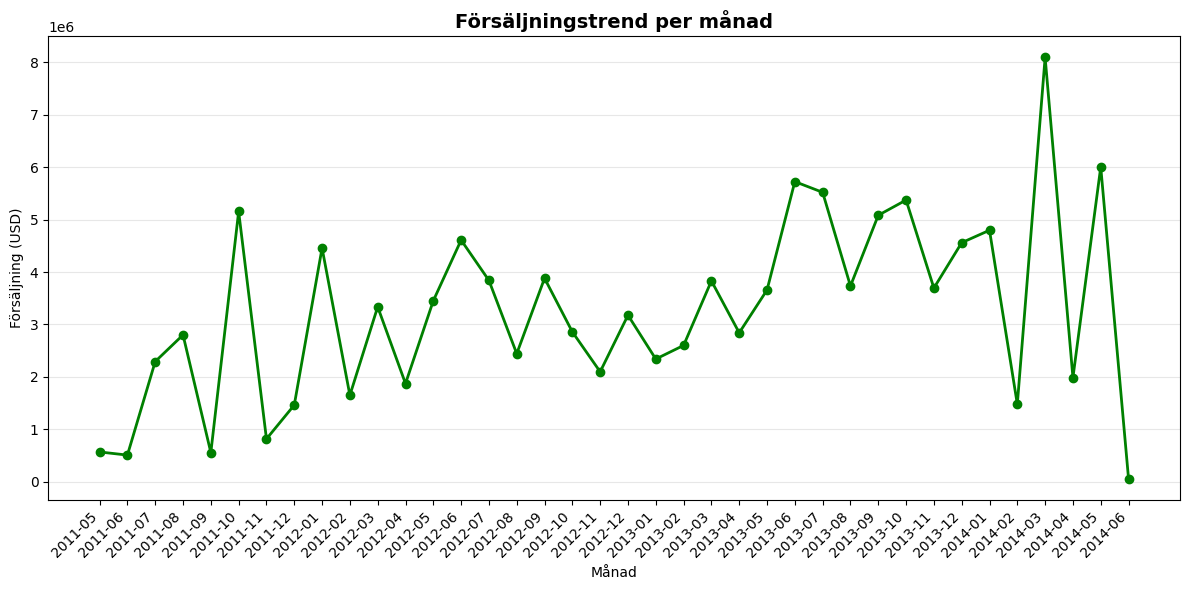

,Manad,TotalForsaljning
0,2011-05,5.670209e+05
1,2011-06,5.070965e+05
2,2011-07,2.292183e+06
3,2011-08,2.800576e+06
4,2011-09,5.547916e+05
5,2011-10,5.156270e+06
6,2011-11,8.153130e+05
7,2011-12,1.462449e+06
8,2012-01,4.458337e+06
9,2012-02,1.649052e+06


In [11]:
# Skolvideo: Funktioner
query = """
SELECT 
    FORMAT(OrderDate, 'yyyy-MM') AS Manad,
    SUM(TotalDue) AS TotalForsaljning
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY Manad;
"""

conn = pymssql.connect(server=server, user=user, password=password, database=database)
df3 = pd.read_sql(query, conn)
conn.close()

# Visualisering - Linjediagram
plt.figure(figsize=(12, 6))
plt.plot(df3['Manad'], df3['TotalForsaljning'], marker='o', linewidth=2, color='green')
plt.title('Försäljningstrend per månad', fontsize=14, fontweight='bold')
plt.xlabel('Månad')
plt.ylabel('Försäljning (USD)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

df3.head(15)  # Visar första 15 månader


**Insikt**: 

Försäljningen visar en **stigande trend** över tid med tydliga säsongsmönster. Högsta försäljning syns i slutet av perioden, medan låga månader ofta förekommer i början av året. Detta kan indikera säsongsvariation kopplat till cykelsäsong.


## 4. Försäljning och antal ordrar per år

**Affärsfråga**: Hur ser total försäljning och antal ordrar ut per år?

**Metod**: Grupperar per år, visar både SUM(TotalDue) och COUNT(ordrar) i grupperat stapeldiagram.


C:\Users\riera\AppData\Local\Temp\ipykernel_24648\1373792206.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df4 = pd.read_sql(query, conn)


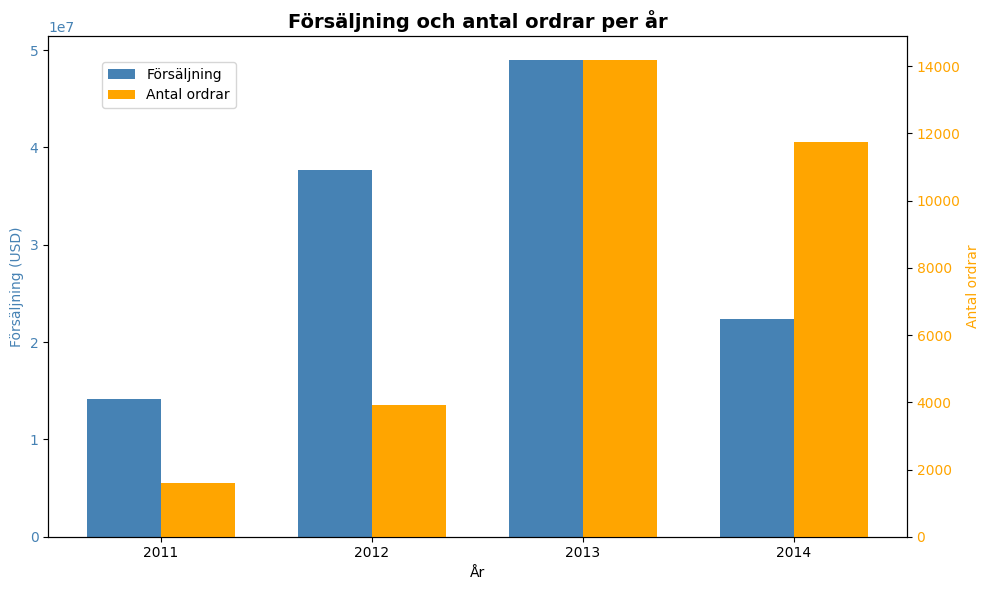

,Ar,TotalForsaljning,AntalOrdrar
0,2011,1.415570e+07,1607
1,2012,3.767570e+07,3915
2,2013,4.896589e+07,14182
3,2014,2.241950e+07,11761


In [12]:
# Skolvideo: Aggregering, Gruppering
query = """
SELECT 
    YEAR(OrderDate) AS Ar,
    SUM(TotalDue) AS TotalForsaljning,
    COUNT(SalesOrderID) AS AntalOrdrar
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY Ar;
"""

conn = pymssql.connect(server=server, user=user, password=password, database=database)
df4 = pd.read_sql(query, conn)
conn.close()

# Visualisering - Grupperat stapeldiagram
fig, ax1 = plt.subplots(figsize=(10, 6))

x = range(len(df4))
width = 0.35

ax1.bar([i - width/2 for i in x], df4['TotalForsaljning'], width, label='Försäljning', color='steelblue')
ax1.set_xlabel('År')
ax1.set_ylabel('Försäljning (USD)', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.bar([i + width/2 for i in x], df4['AntalOrdrar'], width, label='Antal ordrar', color='orange')
ax2.set_ylabel('Antal ordrar', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Försäljning och antal ordrar per år', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df4['Ar'])
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()

df4  # Visar data


**Insikt**: 

**2013** hade högst försäljning (~$49M) och flest ordrar (~14,000). Både försäljning och antal ordrar ökade kraftigt från 2011 till 2013, men minskade 2014. Detta kan tyda på marknadsutmaning eller produktcykel som slutade.


## 5. Top 10 produkter efter försäljning

**Affärsfråga**: Vilka 10 produkter genererar mest försäljning?

**Metod**: JOIN Product med SalesOrderDetail, summera LineTotal, ta TOP 10, sorterar högst till lägst.


C:\Users\riera\AppData\Local\Temp\ipykernel_24648\2829413621.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df5 = pd.read_sql(query, conn)


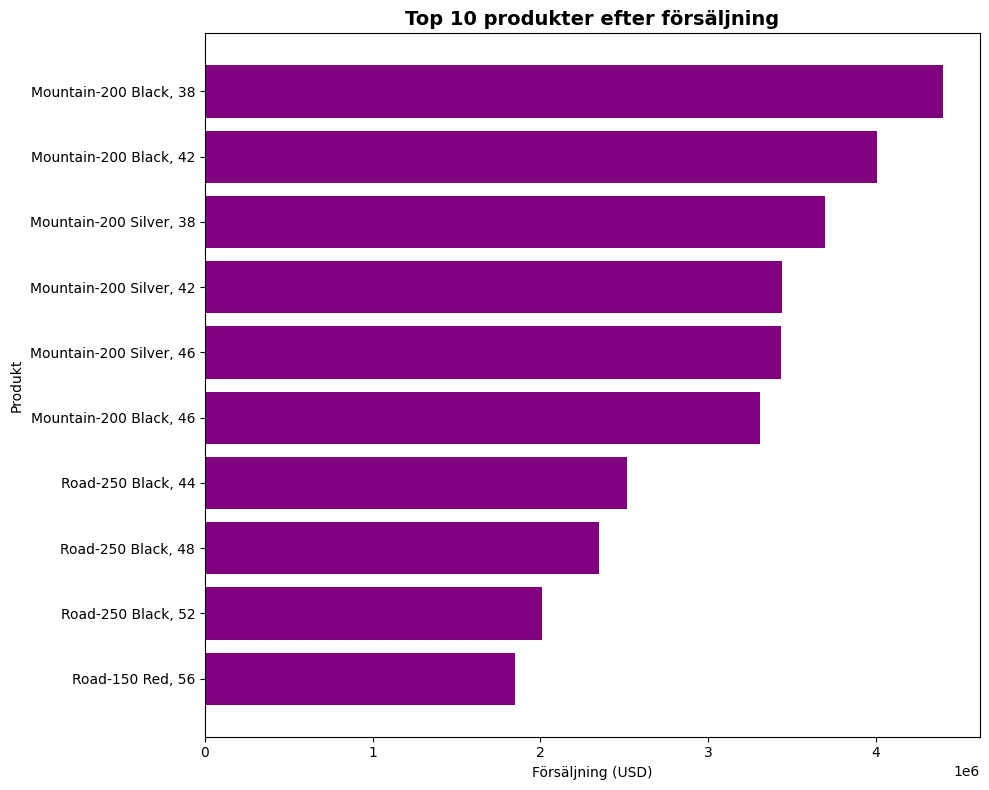

,Produkt,TotalForsaljning
0,"Mountain-200 Black, 38",4.400593e+06
1,"Mountain-200 Black, 42",4.009495e+06
2,"Mountain-200 Silver, 38",3.693678e+06
3,"Mountain-200 Silver, 42",3.438479e+06
4,"Mountain-200 Silver, 46",3.434257e+06
5,"Mountain-200 Black, 46",3.309673e+06
6,"Road-250 Black, 44",2.516857e+06
7,"Road-250 Black, 48",2.347656e+06
8,"Road-250 Black, 52",2.012448e+06
9,"Road-150 Red, 56",1.847819e+06


In [13]:
# Skolvideo: Aggregering, TOP
query = """
SELECT TOP 10
    p.Name AS Produkt,
    SUM(sod.LineTotal) AS TotalForsaljning
FROM Production.Product p
JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
GROUP BY p.Name
ORDER BY TotalForsaljning DESC;
"""

conn = pymssql.connect(server=server, user=user, password=password, database=database)
df5 = pd.read_sql(query, conn)
conn.close()

# Visualisering - Horisontellt stapeldiagram
plt.figure(figsize=(10, 8))
plt.barh(df5['Produkt'], df5['TotalForsaljning'], color='purple')
plt.title('Top 10 produkter efter försäljning', fontsize=14, fontweight='bold')
plt.xlabel('Försäljning (USD)')
plt.ylabel('Produkt')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

df5


**Insikt**: 

Den bäst säljande produkten är **Mountain-200 Black, 38** med ~$1.3M i försäljning. **Bikes-kategorin dominerar** topp 10-listan, vilket bekräftar att cyklar är huvudaffären.


## 6. Försäljning och antal kunder per region

**Affärsfråga**: Hur skiljer sig försäljningen mellan regioner, och hur många unika kunder har varje region?

**Metod**: JOIN SalesTerritory, SalesOrderHeader, Customer. Gruppera per region, visa både SUM(TotalDue) och COUNT DISTINCT(CustomerID).


C:\Users\riera\AppData\Local\Temp\ipykernel_24648\1170599706.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df6 = pd.read_sql(query, conn)


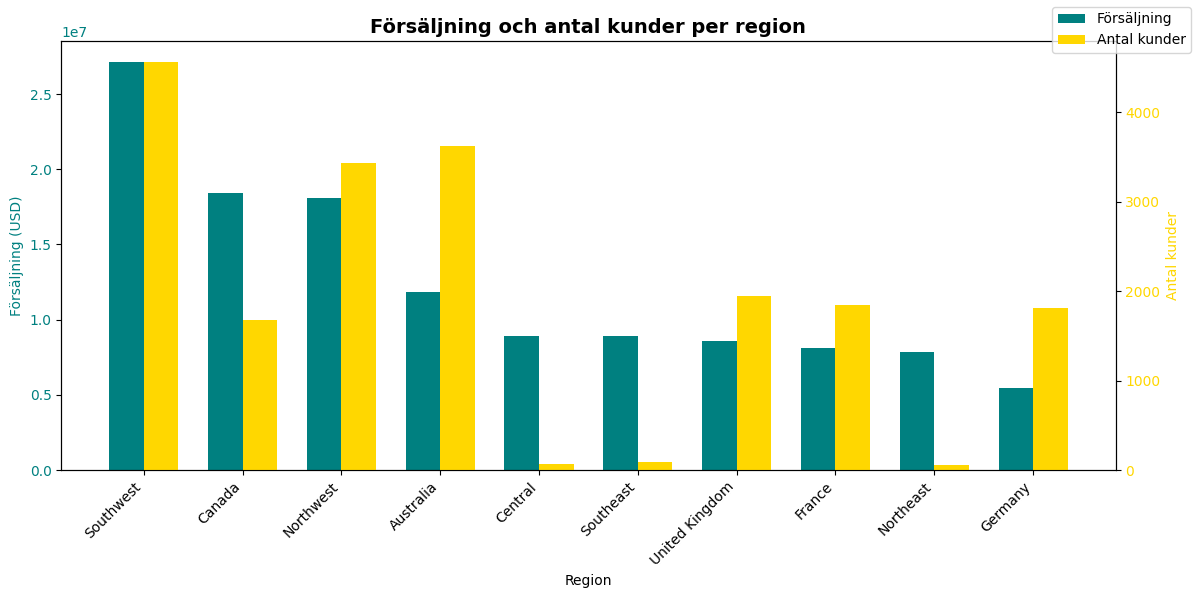

,Region,TotalForsaljning,AntalKunder
0,Southwest,2.715059e+07,4565
1,Canada,1.839893e+07,1677
2,Northwest,1.806166e+07,3428
3,Australia,1.181438e+07,3625
4,Central,8.913299e+06,69
5,Southeast,8.884099e+06,91
6,United Kingdom,8.574049e+06,1951
7,France,8.119749e+06,1844
8,Northeast,7.820210e+06,57
9,Germany,5.479820e+06,1812


In [14]:
# Skolvideo: JOINs, COUNT DISTINCT
query = """
SELECT 
    st.Name AS Region,
    SUM(soh.TotalDue) AS TotalForsaljning,
    COUNT(DISTINCT soh.CustomerID) AS AntalKunder
FROM Sales.SalesTerritory st
JOIN Sales.SalesOrderHeader soh ON st.TerritoryID = soh.TerritoryID
GROUP BY st.Name
ORDER BY TotalForsaljning DESC;
"""

conn = pymssql.connect(server=server, user=user, password=password, database=database)
df6 = pd.read_sql(query, conn)
conn.close()

# Visualisering - Grupperat stapeldiagram
fig, ax1 = plt.subplots(figsize=(12, 6))
x = range(len(df6))
width = 0.35

ax1.bar([i - width/2 for i in x], df6['TotalForsaljning'], width, label='Försäljning', color='teal')
ax1.set_xlabel('Region')
ax1.set_ylabel('Försäljning (USD)', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')

ax2 = ax1.twinx()
ax2.bar([i + width/2 for i in x], df6['AntalKunder'], width, label='Antal kunder', color='gold')
ax2.set_ylabel('Antal kunder', color='gold')
ax2.tick_params(axis='y', labelcolor='gold')

plt.title('Försäljning och antal kunder per region', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df6['Region'], rotation=45, ha='right')
fig.legend(loc='upper right')
plt.tight_layout()
plt.show()

df6 # Visar data nedan


**Insikt**: 

**Southwest** är starkast med högst försäljning och många kunder. Regioner med hög försäljning men färre kunder har högre ordervärde per kund—indikerar företagskunder eller premium-segment.


## 7. Genomsnittligt ordervärde per region och kundtyp

**Affärsfråga**: Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan företagskunder (Store) och privatpersoner (Individual)?

**Metod**: Beräkna AVG(TotalDue) per region, dela upp på kundtyp (StoreID NULL = Individual).


C:\Users\riera\AppData\Local\Temp\ipykernel_24648\1214877124.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df7 = pd.read_sql(query, conn)


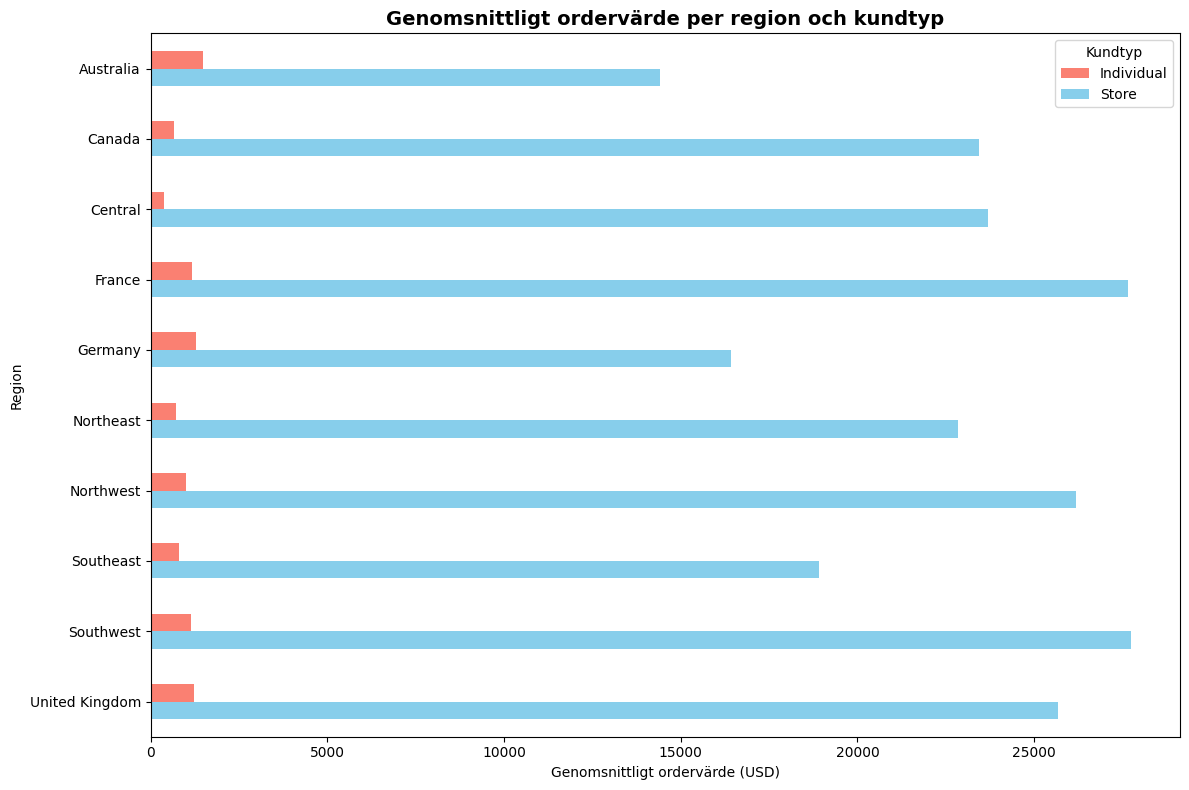

,Region,Kundtyp,GenomsnittligtOrdervarde
0,Australia,Individual,1490.3849
1,Australia,Store,14415.7618
2,Canada,Individual,647.5610
3,Canada,Store,23429.7839
4,Central,Individual,368.4352
5,Central,Store,23696.7641
6,France,Individual,1176.1834
7,France,Store,27649.5197
8,Germany,Individual,1287.5262
9,Germany,Store,16414.4199


In [15]:
# Skolvideo: CASE, AVG
query = """
SELECT 
    st.Name AS Region,
    CASE WHEN c.StoreID IS NULL THEN 'Individual' ELSE 'Store' END AS Kundtyp,
    AVG(soh.TotalDue) AS GenomsnittligtOrdervarde
FROM Sales.SalesTerritory st
JOIN Sales.SalesOrderHeader soh ON st.TerritoryID = soh.TerritoryID
JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
GROUP BY st.Name, CASE WHEN c.StoreID IS NULL THEN 'Individual' ELSE 'Store' END
ORDER BY Region, Kundtyp;
"""

conn = pymssql.connect(server=server, user=user, password=password, database=database)
df7 = pd.read_sql(query, conn)
conn.close()

# Pivot för gruppering
df7_pivot = df7.pivot(index='Region', columns='Kundtyp', values='GenomsnittligtOrdervarde').fillna(0)

# Visualisering
df7_pivot.plot(kind='barh', figsize=(12, 8), color=['salmon', 'skyblue'])
plt.title('Genomsnittligt ordervärde per region och kundtyp', fontsize=14, fontweight='bold')
plt.xlabel('Genomsnittligt ordervärde (USD)')
plt.ylabel('Region')
plt.legend(title='Kundtyp')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

df7


**Insikt**: 

**Store-kunder** (företag) har genomgående högre ordervärde än **Individual-kunder** i alla regioner. Detta visar att B2B-segmentet är mer lönsamt per order. Regioner med starkast Store-genomsnitt bör prioriteras för företagsförsäljning.


## Sammanfattning

### Huvudsakliga fynd:

1. **Produktportfölj**: Components dominerar antal produkter (134 st), men Bikes genererar överlägset mest intäkter
2. **Försäljningstrend**: Stark tillväxt 2011-2013, med topp 2013 (~$49M). Nedgång 2014 kräver analys
3. **Top-produkter**: Premium-cyklar dominerar topp 10, bekräftar fokus på högvärdesprodukter
4. **Regional styrka**: Southwest leder försäljning och kundantal
5. **Kundtyp**: B2B (Store) har 2-3x högre ordervärde än B2C (Individual)

### Rekommendationer:

- **Utöka B2B-satsning**: Store-kunder ger högre ordervärde—fokusera marknadsföring mot företag
- **Analysera 2014-nedgång**: Identifiera orsaker (konkurrens, produktcykel, marknad) för att vända trend
- **Regional expansion**: Stärk närvaro i högpresterande regioner, utvärdera svaga regioner
- **Produktmix**: Balansera Bikes-dominans med tillväxt i Accessories/Components för diversifiering
